In [1]:
# importing module
import sys
import os
from pathlib import Path
sys.path.append(str(Path.cwd().parent))
from myutils import *
from SLBQP import SLBQP
from datastorer import DataStorer

In [2]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import time
plt.style.use('seaborn')
params = {
    'figure.figsize': (20, 10),
    'legend.fontsize': 'x-large',
    'axes.labelsize': 'x-large',
    'axes.titlesize':'x-large',
    'xtick.labelsize':'x-large',
    'ytick.labelsize':'x-large',
    'axes.titlesize': 'x-large',
}
plt.rcParams.update(params)

In [3]:
seed = None     # random seed
n = 100         # dimension
u = 1.          # upperbound
epsilon = 0.1   #
np.random.seed(seed)

In [5]:
feat, targ = load_ml_dataset()
t1 = targ[:,0]
t2 = targ[:,1]

loading from: 
/Users/gerardozinno/repos/ProgettoML/cm/data/ML-CUP19-TR.csv


In [6]:
targ = t1
targ

array([ 4.13091198, 29.49904525, 24.14576734, ..., 30.17470543,
       26.4072482 , 14.35999224])

In [7]:
K, target = sample_transform_problem(feat, targ, len(targ), seed)

In [8]:
problem_sizes = (100, 200, 300)#, 400, 500, 600, 700, 800, 900, 1000)
n_prob = 2
problems = [[sample_transform_problem(feat, targ, size, seed) for size in problem_sizes] for _ in range(n_prob)]

In [9]:
ROSEN = 2
GOLDSTEIN = 1

In [10]:
%%time
ds = DataStorer()
prj_type = GOLDSTEIN
sg, xg, vg, itg = SLBQP(K, target, u, epsilon, eps=1e-6, maxIter=-1, lmb0=0, d_lmb=2, prj_eps=1e-9, verbose=False, prj_type=prj_type, ds=ds)


CPU times: user 2min 13s, sys: 7.66 s, total: 2min 21s
Wall time: 1min 23s


In [11]:
ds.save_to_file("GOLDSTEIN_WHOLE_ML_DATASET.csv")
print(f"x: {xg} ({sg})\tv: {vg}\titer: {itg}")

x: [0. 0. 0. ... 1. 0. 0.] (optimal)	v: -5793.474916445437	iter: 5367


In [12]:
%%time
ds = DataStorer()
prj_type = ROSEN
sr, xr, vr, itr = SLBQP(K, target, u, epsilon, eps=1e-6, maxIter=-1, lmb0=0, d_lmb=2, prj_eps=1e-9, verbose=False, prj_type=prj_type, ds=ds)
ds.save_to_file("ROSEN.csv")
print(f"x: {xr} ({sr})\tv: {vr}\titer: {itr}")

x: [0. 0. 0. ... 1. 0. 0.] (optimal)	v: -5793.474916445259	iter: 9106
CPU times: user 6min 31s, sys: 27.4 s, total: 6min 58s
Wall time: 4min 44s


In [13]:
np.linalg.norm(vr-vg)

3.3651303965598345e-11

In [14]:
prj_type = GOLDSTEIN
goldstein_results = []
for run in problems:
    goldstein_temp = []
    for (K, target) in run:
        start = time.time()
        results = (*SLBQP(K, target, u, epsilon, eps=1e-6, maxIter=-1, lmb0=0, d_lmb=2, prj_eps=1e-9, verbose=False, prj_type=prj_type), time.time()-start)
        goldstein_temp.append(results)
    goldstein_results.append(goldstein_temp) 

In [15]:
len(goldstein_results)

2

In [18]:
zipped_results = [list(zip(*goldstein_results[i])) for i in range(len(goldstein_results))]
iterations = []
times = []
for z in zipped_results:
    iterations.append(z[3])
    times.append(z[4])
gold_average_iter = [sum(x)/len(iterations) for x in zip(*iterations)]
gold_average_time = [sum(x)/len(times) for x in zip(*times)]
print(gold_average_iter, gold_average_time, sep='\n')

[21.0, 85.5, 38.0]
[0.03954136371612549, 0.12411701679229736, 0.04886651039123535]


In [19]:
def comparison_plot(element1, label1, element2, label2, xaxis=problem_sizes):
    fix, axs = plt.subplots(ncols=2)
    axs[0].plot(xaxis, element1, '--o')
    axs[0].set_xlabel('problem size')
    axs[0].set_ylabel(label1)
    axs[1].plot(problem_sizes, element2, '--o')
    axs[1].set_xlabel('problem size')
    axs[1].set_ylabel(label2)
    plt.show()


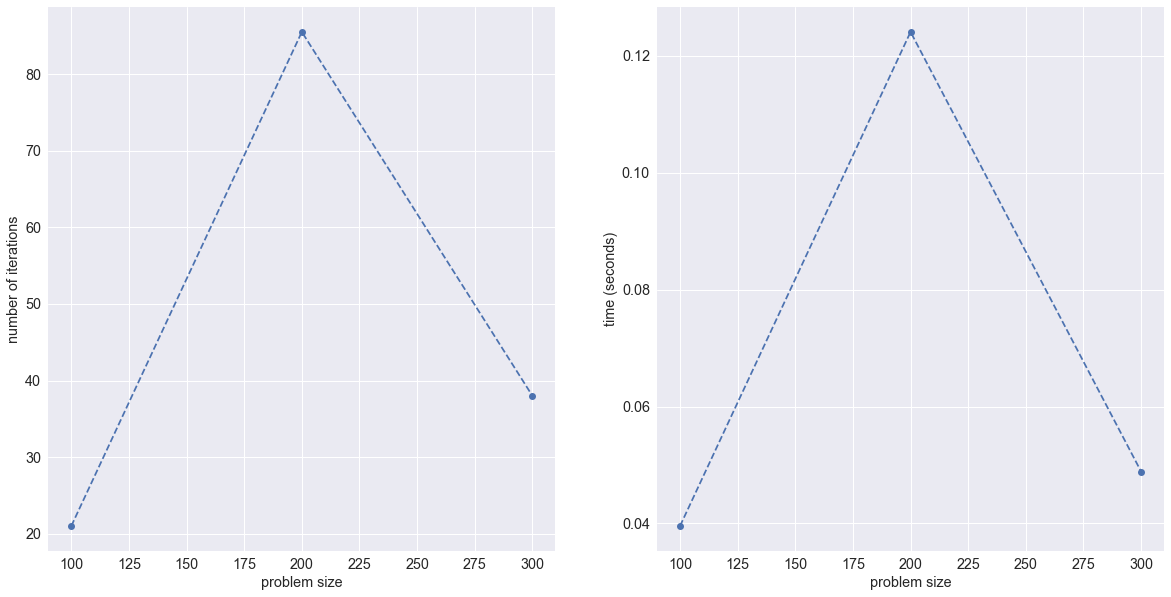

In [20]:
comparison_plot(gold_average_iter, "number of iterations", gold_average_time, "time (seconds)")

# TODO  
* Calcolare algoritmo su problemi diversi e plottare media
* Vel. conv: prendiamo ottimo risolutore, ad ogni passo plottare valore fun e f* - fi / fi-1 - f*
* Sperimentare con altri parametri
* Confrontare tempi senza numba